In [147]:
import pandas as pd
from urllib.request import urlopen  
import os.path as osp
import os
import logging
import zipfile
from glob import glob
logging.getLogger().setLevel('INFO')
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.animation as animation

## Helpers

In [3]:
def download_file(url_str, path):
    url = urlopen(url_str)
    output = open(path, 'wb')       
    output.write(url.read())
    output.close()  
    
def extract_file(archive_path, target_dir):
    zip_file = zipfile.ZipFile(archive_path, 'r')
    zip_file.extractall(target_dir)
    zip_file.close()

## Download the dataset

In [5]:
BASE_URL = 'http://tennis-data.co.uk'
DATA_DIR = "tennis_data"
ATP_DIR = './{}/ATP'.format(DATA_DIR)
WTA_DIR = './{}/WTA'.format(DATA_DIR)

ATP_URLS = [BASE_URL + "/%i/%i.zip" % (i,i) for i in range(2000,2019)]
WTA_URLS = [BASE_URL + "/%iw/%i.zip" % (i,i) for i in range(2007,2019)]

os.makedirs(osp.join(ATP_DIR, 'archives'), exist_ok=True)
os.makedirs(osp.join(WTA_DIR, 'archives'), exist_ok=True)

# for files, directory in ((ATP_URLS, ATP_DIR), (WTA_URLS, WTA_DIR)):
#     for dl_path in files:
#         logging.info("downloading & extracting file %s", dl_path)
#         archive_path = osp.join(directory, 'archives', osp.basename(dl_path))
#         download_file(dl_path, archive_path)
#         extract_file(archive_path, directory)
    
ATP_FILES = sorted(glob("%s/*.xls*" % ATP_DIR))
WTA_FILES = sorted(glob("%s/*.xls*" % WTA_DIR))

df_atp = pd.concat([pd.read_excel(f) for f in ATP_FILES], ignore_index=True,sort=False)
df_wta = pd.concat([pd.read_excel(f) for f in WTA_FILES], ignore_index=True,sort=False)

logging.info("%i matches ATP in df_atp", df_atp.shape[0])
logging.info("%i matches WTA in df_wta", df_wta.shape[0])

INFO:root:52298 matches ATP in df_atp
INFO:root:29581 matches WTA in df_wta


## Your work

## Questions

### 1. Who are the three ATP players with the most wins ?

In [6]:
df_atp['Winner'].value_counts().head(3)

Federer R.     1121
Nadal R.        891
Djokovic N.     802
Name: Winner, dtype: int64

### 2. How many sets did the player “Federer R.” win in total ? 

In [23]:
#Take loser into account to count the sets that Federer won but lost the game

federer_sets = df_atp.loc[(df_atp['Winner']=='Federer R.') | (df_atp['Loser'] == 'Federer R.')] 
federer_sets['Wsets'].value_counts().sum() + federer_sets['Lsets'].value_counts().sum()

0

### 3. How many sets did the player “Federer R.” win during the years 2016 and 2017 ?

In [19]:
federer_2016_17 = federer_sets.loc[(federer_sets['Date'].dt.year == 2016) | (federer_sets['Date'].dt.year == 2017)]
federer_2016_17['Wsets'].value_counts().sum() + federer_2016_17['Lsets'].value_counts().sum()

170

### 4. For each match, what is the percentage of victories of the winner in the past ?

In [218]:
def previous_victory_percentages(player_name):
    player_record = df_atp.loc[(df_atp['Winner'] == player_name) | (df_atp['Loser'] == player_name)]
    player_record = player_record.filter(['ATP', 'Date', 'Winner', 'Loser'])
    all_victory_percentages = list()

    for index, row in player_record.iterrows():
        player_latest_victories = player_record.loc[(player_record['Winner'] == player_name) &
                                              (player_record['Date']<row.Date)]
        
        games_played_till_now = player_record.loc[player_record['Date']<row.Date]
        
        current_victory_percentage = (player_latest_victories.ATP.count() /games_played_till_now.ATP.count()) * 100
        all_victory_percentages.append(current_victory_percentage)
    
    return all_victory_percentages

In [216]:
fed_perc = previous_victory_percentages('Federer R.')
fed_perc

/home/devendra/myinstallations/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


[nan,
 nan,
 50.0,
 33.33333333333333,
 33.33333333333333,
 33.33333333333333,
 50.0,
 50.0,
 50.0,
 50.0,
 50.0,
 63.63636363636363,
 63.63636363636363,
 63.63636363636363,
 64.28571428571429,
 64.28571428571429,
 64.28571428571429,
 64.28571428571429,
 66.66666666666666,
 66.66666666666666,
 65.0,
 61.904761904761905,
 59.09090909090909,
 56.52173913043478,
 54.166666666666664,
 52.0,
 52.0,
 52.0,
 52.0,
 55.172413793103445,
 55.172413793103445,
 55.172413793103445,
 56.25,
 54.54545454545454,
 52.94117647058824,
 51.42857142857142,
 50.0,
 48.64864864864865,
 47.368421052631575,
 47.368421052631575,
 47.368421052631575,
 48.78048780487805,
 48.78048780487805,
 48.78048780487805,
 48.78048780487805,
 51.11111111111111,
 51.11111111111111,
 51.11111111111111,
 51.11111111111111,
 51.11111111111111,
 54.0,
 54.0,
 53.84615384615385,
 53.84615384615385,
 53.70370370370371,
 52.72727272727272,
 52.72727272727272,
 52.63157894736842,
 52.63157894736842,
 52.63157894736842,
 53.3333333333

### Let's Plot it....

<IPython.core.display.Javascript object>


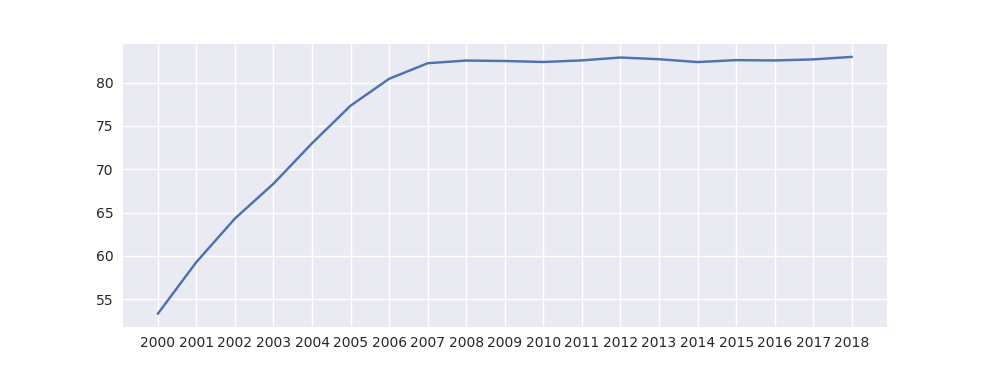

In [217]:
%matplotlib notebook

#create a separate dataframe for plotting by taking year-wise average of previous victory percentages 
plot_data = player_record

plot_data['Year'] = player_record['Date'].dt.year
plot_data['previous_victory_percentages'] = fed_perc

plot_data = plot_data.groupby(['Year'],as_index=False).mean()
plot_data.filter(['Year', 'previous_victory_percentages'])

plt.xticks(plot_data['Year'])
plt.plot(plot_data['Year'], plot_data['previous_victory_percentages'])


In [60]:
player_latest_records.shape

(1293, 54)